## 다수의 사람 얼굴을 기준으로 스티커 붙이기 

dlib의 landmark를 활용해 이미지 속 다수의 사람에게 스티커를 붙여주는 프로젝트를 진행해 보겠습니다.  

- WIDER FACE 데이터셋을 사용한 SSD 모델을 이용해 사람의 얼굴 boundgin box를 찾습니다.  

### 필요한 Module import 

In [3]:
import tensorflow as tf
import os
import cv2
import numpy as np

import python.config 
from python.make_prior_box import prior_box
from python.tf_dataloader import load_dataset, _jaccard 
from python.tf_build_ssd_model import SsdModel

import warnings
warnings.filterwarnings(action='ignore')


## Inference(1) NMS

### NMS 구현하기
---
Grid cell을 사용하는 Object detection의 inference 단계에서 하나의 object가 여러 개의 prior box에 걸쳐져 있을 때 가장 확률이 높은 1개의 prior box를 하나로 줄여주는 **NMS(non-max suppression)**이 필요합니다. 아래 코드를 확인해 주세요.

In [12]:
def decode_bbox_tf(pre, priors, variances=None):
    """Decode locations from predictions using prior to undo
    the encoding we did for offset regression at train time.
    Args:
        pre (tensor): location predictions for loc layers,
            Shape: [num_prior,4]
        prior (tensor): Prior boxes in center-offset form.
            Shape: [num_prior,4].
        variances: (list[float]) Variances of prior boxes
    Return:
        decoded bounding box predictions xmin, ymin, xmax, ymax
    """
    if variances is None:
        variances = [0.1, 0.2]
    centers = priors[:, :2] + pre[:, :2] * variances[0] * priors[:, 2:]
    sides = priors[:, 2:] * tf.math.exp(pre[:, 2:] * variances[1])

    return tf.concat([centers - sides / 2, centers + sides / 2], axis=1)

In [13]:
def compute_nms(boxes, scores, nms_threshold=0.5, limit=200):
    """ Perform Non Maximum Suppression algorithm
        to eliminate boxes with high overlap
    Args:
        boxes: tensor (num_boxes, 4)
               of format (xmin, ymin, xmax, ymax)
        scores: tensor (num_boxes,)
        nms_threshold: NMS threshold
        limit: maximum number of boxes to keep
    Returns:
        idx: indices of kept boxes
    """
    if boxes.shape[0] == 0:
        return tf.constant([], dtype=tf.int32)
    selected = [0]
    idx = tf.argsort(scores, direction='DESCENDING')
    idx = idx[:limit]
    boxes = tf.gather(boxes, idx)

    iou = _jaccard(boxes, boxes)

    while True:
        row = iou[selected[-1]]
        next_indices = row <= nms_threshold

        iou = tf.where(
            tf.expand_dims(tf.math.logical_not(next_indices), 0),
            tf.ones_like(iou, dtype=tf.float32),
            iou)

        if not tf.math.reduce_any(next_indices):
            break

        selected.append(tf.argsort(
            tf.dtypes.cast(next_indices, tf.int32), direction='DESCENDING')[0].numpy())

    return tf.gather(idx, selected)

In [14]:
def parse_predict(predictions, priors, cfg):
    label_classes = cfg['labels_list']

    bbox_regressions, confs = tf.split(predictions[0], [4, -1], axis=-1)
    boxes = decode_bbox_tf(bbox_regressions, priors, cfg['variances'])


    confs = tf.math.softmax(confs, axis=-1)

    out_boxes = []
    out_labels = []
    out_scores = []

    for c in range(1, len(label_classes)):
        cls_scores = confs[:, c]

        score_idx = cls_scores > cfg['score_threshold']

        cls_boxes = boxes[score_idx]
        cls_scores = cls_scores[score_idx]

        nms_idx = compute_nms(cls_boxes, cls_scores, cfg['nms_threshold'], cfg['max_number_keep'])

        cls_boxes = tf.gather(cls_boxes, nms_idx)
        cls_scores = tf.gather(cls_scores, nms_idx)

        cls_labels = [c] * cls_boxes.shape[0]

        out_boxes.append(cls_boxes)
        out_labels.extend(cls_labels)
        out_scores.append(cls_scores)

    out_boxes = tf.concat(out_boxes, axis=0)
    out_scores = tf.concat(out_scores, axis=0)

    boxes = tf.clip_by_value(out_boxes, 0.0, 1.0).numpy()
    classes = np.array(out_labels)
    scores = out_scores.numpy()

    return boxes, classes, scores

In [123]:
predictions[0]

array([[276.76328   ,  83.95625   ,   1.1971525 ,   1.2168007 ,
          1.7605928 ,   1.4005871 ],
       [  2.4475305 ,   2.8478663 ,  -2.7129602 ,  -3.3897805 ,
          3.7530403 ,  -1.3943709 ],
       [  2.8110518 ,   3.0627232 ,  -2.1330607 ,  -2.2409267 ,
          1.9556535 ,  -3.303263  ],
       ...,
       [  0.71098197,   0.5827886 ,  -4.6154633 ,  -4.366546  ,
          2.9226108 ,  -2.6779127 ],
       [  0.81990266,   1.1227167 ,  -4.780661  ,  -4.9148593 ,
          2.8596745 ,  -2.2150428 ],
       [  0.6082241 ,   0.53062236,  -5.4604053 ,  -6.4311743 ,
          2.4843016 ,  -2.4353428 ]], dtype=float32)

---

## Inference(2) 사진에서 얼굴 찾기

### 사진에서 여러개의 얼굴을 찾아보자.

---

이제 다 왔습니다. SSD 모델을 통해 우리는 Multi-face detection 기능을 확보했습니다.
얼마나 잘 해내는지 확인해 보도록 합시다.

In [15]:
def pad_input_image(img, max_steps):
    """pad image to suitable shape"""
    img_h, img_w, _ = img.shape

    img_pad_h = 0
    if img_h % max_steps > 0:
        img_pad_h = max_steps - img_h % max_steps

    img_pad_w = 0
    if img_w % max_steps > 0:
        img_pad_w = max_steps - img_w % max_steps

    padd_val = np.mean(img, axis=(0, 1)).astype(np.uint8)
    img = cv2.copyMakeBorder(img, 0, img_pad_h, 0, img_pad_w,
                             cv2.BORDER_CONSTANT, value=padd_val.tolist())
    pad_params = (img_h, img_w, img_pad_h, img_pad_w)

    return img, pad_params

In [102]:
def recover_pad_output(outputs, pad_params):
    """
        recover the padded output effect

    """
    img_h, img_w, img_pad_h, img_pad_w = pad_params

    recover_xy = np.reshape(outputs[0], [-1, 2, 2]) * \
                 [(img_pad_w + img_w) / img_w, (img_pad_h + img_h) / img_h]
    outputs[0] = np.reshape(recover_xy, [-1, 4])

    return outputs

In [52]:
def show_image(img, boxes, classes, scores, img_height, img_width, prior_index, class_list):
    """
    draw bboxes and labels
    out:boxes,classes,scores
    """
    # bbox

    x1, y1, x2, y2 = int(boxes[prior_index][0] * img_width), int(boxes[prior_index][1] * img_height), \
                     int(boxes[prior_index][2] * img_width), int(boxes[prior_index][3] * img_height)
    if classes[prior_index] == 1:
        color = (0, 255, 0)
    else:
        color = (0, 0, 255)
    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
    # confidence

    # if scores:
    #   score = "{:.4f}".format(scores[prior_index])
    #   class_name = class_list[classes[prior_index]]

    #  cv2.putText(img, '{} {}'.format(class_name, score),
    #              (int(boxes[prior_index][0] * img_width), int(boxes[prior_index][1] * img_height) - 4),
    #              cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255))

inference와 화면출력을 위한 몇가지 기능을 추가하였습니다.

여러 사람의 얼굴이 포함된 테스트용 이미지를 골라 주세요. **`~/aiffel/face_detector/image.png`**라는 경로로 저장 후 아래 코드를 실행해 보세요.

[*] model path : /home/ssac27/aiffel/face_detector/checkpoints/weights_epoch_100.h5
[*] Predict /home/ssac27/aiffel/face_detector/image.png image.. 
[*] image.shape:(256, 384, 3)
[*] scores:[0.9973863  0.9497202  0.8504004  0.84510845]
[*] boxes:[[0.09457996 0.4289357  0.17245075 0.54027706]
 [0.49819195 0.43223998 0.5735923  0.5380017 ]
 [0.7213179  0.42415696 0.8009161  0.5373392 ]
 [0.30025882 0.43129602 0.3726101  0.53268826]]
[*] save_img_path:/home/ssac27/aiffel/face_detector/assets/out_image.png


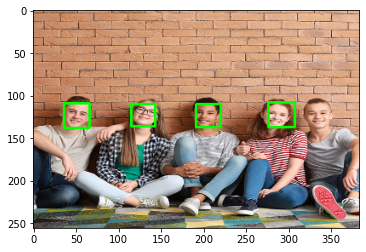

In [310]:

# hyperparameters
# args = argparse.ArgumentParser()
# args.add_argument('model_path', type=str, nargs='?', default='checkpoints/')
# args.add_argument('img_path', type=str, nargs='?', default='images/')
# args.add_argument('camera', type=str, nargs='?', default=False)

# args_config = args.parse_args()
# args_config = "images/image.png"



global model

cfg = config.cfg
min_sizes = cfg['min_sizes']
num_cell = [len(min_sizes[k]) for k in range(len(cfg['steps']))]
model_path = os.getenv('HOME')+'/aiffel/face_detector/checkpoints'
img_path = os.getenv('HOME')+'/aiffel/face_detector/image.png'

try:
    model = SsdModel(cfg=cfg, num_cell=num_cell, training=False)

    paths = [os.path.join(model_path, path)
             for path in os.listdir(model_path)]
    latest = sorted(paths, key=os.path.getmtime)[-1]
    model.load_weights(latest)
    print(f"[*] model path : {latest}")

except AttributeError as e:
    print('Please make sure there is at least one weights at {}'.format(model_path))

if not os.path.exists(img_path):
    print(f"Cannot find image path from {img_path}")
    exit()
    
print("[*] Predict {} image.. ".format(img_path))
img_raw = cv2.imread(img_path)
img_raw = cv2.resize(img_raw, (384, 256)) #384, 256
img_height_raw, img_width_raw, _ = img_raw.shape
img = np.float32(img_raw.copy())

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# pad input image to avoid unmatched shape problem
img, pad_params = pad_input_image(img, max_steps=max(cfg['steps']))
img = img / 255.0 - 0.5

print(f"[*] image.shape:{img.shape}")
priors, _ = prior_box(cfg, image_sizes=(img.shape[0], img.shape[1]))
priors = tf.cast(priors, tf.float32)


predictions = model.predict(img[np.newaxis, ...] )

boxes, classes, scores = parse_predict(predictions, priors, cfg)

print(f"[*] scores:{scores}")

# recover padding effect
boxes = recover_pad_output(boxes, pad_params)

print(f"[*] boxes:{boxes}")

# draw and save results
# save_img_path = os.path.join('assets/out_' + img_path)
save_img_path = os.getenv('HOME')+'/aiffel/face_detector/assets/out_image.png'
print(f"[*] save_img_path:{save_img_path}")

for prior_index in range(len(boxes)):
    score = "{:.4f}".format(scores[prior_index])
    class_name = cfg['labels_list']
    show_image(img_raw, boxes, classes, scores, img_height_raw, img_width_raw, prior_index, cfg['labels_list'])

cv2.imwrite(save_img_path, img_raw)
cv2.imshow('results', img_raw)
img_rgb = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

# if cv2.waitKey(0) == ord('q'):
#     exit(0)
if cv2.waitKey(100) and 0xFF == ord('q'):
    exit(0)
cv2.destroyAllWindows()

``` python
# 이슈 발생
WARNING:tensorflow:5 out of the last 5 calls to <function _make_execution_function.<locals>. 
```
- 추정 원인 : Model을 만들었을때와 현재 library의 버전 차이

---

## image Sticker 

SSD model을 사용해 image의 boxes와 scores를 구했으니 이제 스티커를 붙일 차례입니다.  

스티커를 구하고 SSD, dlib 등을 활용해 얼굴 bbox를 구합니다.   
구한 bbox에 landmark를 그린 후 이미지에 넣고 싶은 스티커에 맞게 좌표와 비율을 조정해서 스티커를 이미지에 붙여봅시다.

### 1) 스티커 구하기
---

왕관 또는 고양이 수염, 혹은 다양한 아이디어의 스티커를 만들어 볼 수 있을 것입니다.   
스티커를 붙일 사진과 해당 사진에 붙일 스티커를 찾아봅시다.  

In [311]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf


home_dir = os.getenv('HOME') + '/aiffel/face_detector'

In [312]:
home_dir

'/home/ssac27/aiffel/face_detector'

스티커를 붙일 이미지 확인

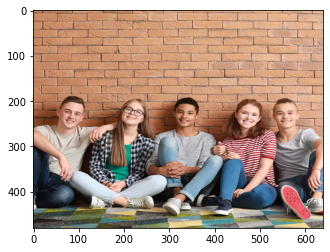

In [313]:
img_path = os.path.join(home_dir,'image.png')

img_bgr = cv2.imread(img_path)
img_bgr = cv2.resize(img_bgr, dsize=(640, 480))

img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img)

cv2를 사용해 이미지를 가져왔습니다.   

### 2) SSD 모델을 통해 얼굴 bounding box 
---
SSD model을 활용해 boxes를 찾았습니다. 해당 bbox를 가져온 후 현재 이미지의 width, height 크기를 곱해 현재 이미지에 그릴 수 있는 bbox를 구해봅시다.

- 위의 모델에서 사용한 이미지와 현재 이미지와 비율이 동일하기제 image.shape가 달라도 width, height 값을 사용해서 얼굴 bbox를 그릴 수 있습니다. 

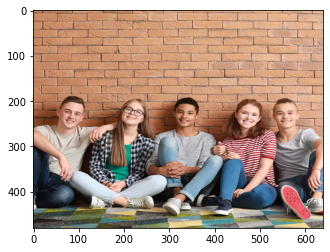

In [314]:
plt.imshow(img)

In [315]:
img.shape

(480, 640, 3)

img boxes  (x1, x2) :  60 , 205     (x2, y2) :  110 , 259
img boxes  (x1, x2) :  318 , 207     (x2, y2) :  367 , 258
img boxes  (x1, x2) :  461 , 203     (x2, y2) :  512 , 257
img boxes  (x1, x2) :  192 , 207     (x2, y2) :  238 , 255


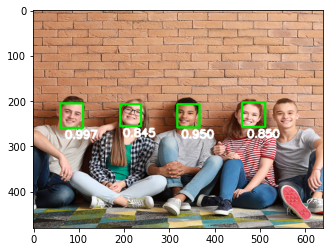

In [317]:
img_show = img.copy() # cv.rectangle()에 사용할 image 복사본

width, height = img_show.shape[1], img_show.shape[0] 

#  bounding  box를 담을 변수
SSD_rects =[]

for i in range(len(boxes)):            # 세로 크기
    x1 = int(boxes[i][0]*width)
    y1 = int(boxes[i][1]*height)
    x2 = int(boxes[i][2]*width)
    y2 = int(boxes[i][3]*height)

    if classes[i] == 1:
        color = (0, 230, 2)
    else:
        color = (0, 0, 255)
    SSD_rects.append([x1, y1, x2, y2])
    cv2.rectangle(img_show, (x1, y1), (x2, y2), color, 4)
    cv2.putText(img_show, '{0:.3f}'.format(scores[i]) , (x2-40,y2+23) ,cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 3)
    print("img boxes  (x1, x2) : ", x1, ",",y1, "    (x2, y2) : ", x2,",", y2)

    plt.imshow(img_show)

In [318]:
scores

array([0.9973863 , 0.9497202 , 0.8504004 , 0.84510845], dtype=float32)

### 3) dlib 을 이용한 landmark 찾기
---
검출된 bounding box별로 dlib을 이용해 face landmark를 찾은 후 plt.imshow를 사용해 확인해 봅시다.

rectangles[[(314, 214) (357, 257)], [(59, 214) (103, 257)], [(535, 214) (578, 257)], [(453, 214) (496, 257)], [(194, 209) (237, 252)]]
314 214 357 257
59 214 103 257
535 214 578 257
453 214 496 257
194 209 237 252


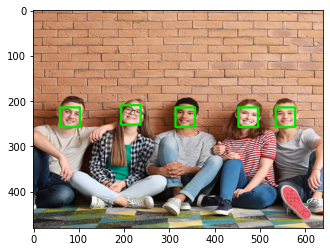

In [328]:
import dlib 

# image resize 
img_dlib = img.copy()

# dlib detector
detector_hog = dlib.get_frontal_face_detector()
landmark_predictor = dlib.shape_predictor('./models/shape_predictor_68_face_landmarks.dat')

dlib_rects = detector_hog(img_dlib, 1)
print(dlib_rects)

for dlib_rect in dlib_rects : 
    #x1 = SSD_rect[0]
    #y1 = SSD_rect[1]
    #x2 = SSD_rect[2]
    #y2 = SSD_rect[3]
    x1 = dlib_rect.left()
    y1 = dlib_rect.top()
    x2 = dlib_rect.right()
    y2 = dlib_rect.bottom()
    print(x1,y1, x2,y2)
    cv2.rectangle(img_dlib, (x1, y1), (x2, y2), (0,230,0), 3 )
    
plt.imshow(img_dlib)

SSD로 사람 얼굴을 detect한 후 detect한 사람 얼굴에서 landmark를 찾는다.

In [320]:
dlib_rects

rectangles[[(314, 214) (357, 257)], [(59, 214) (103, 257)], [(535, 214) (578, 257)], [(453, 214) (496, 257)], [(194, 209) (237, 252)]]

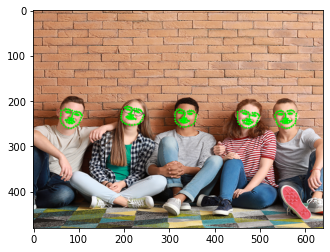

In [321]:
# landmark
list_landmarks = []
img_dlib = img.copy()

for idx, dlib_rect in enumerate(dlib_rects):
    points = landmark_predictor(img_dlib , dlib_rect)   # img, dlib.get_frontal_face_detector()를 사용해서 찾은 dlib_rect
    list_points = list(map(lambda p: (p.x, p.y), points.parts())) # points를 x,y로 분리해서 list에 넣어준다. 
    list_landmarks.append(list_points)
    for landmark in list_landmarks:
        for idx, point in enumerate(list_points):
            cv2.circle(img_dlib, point, 2, (0, 240, 0), -1) # green


plt.imshow(img_dlib)


dlib로 landmark를 찾았고 찾은 landmark가 얼굴 위치에 거의 정확하게 들어가 있습니다. 

### 4) 스티커 합성 사진 생성
---
여러분들이 선택한 인물사진에 스티커를 합성해 봅시다. 이미지에 너무 많은 사람 얼굴이 포함되어 있거나, 검출된 얼굴이 너무 작은 경우 스티커 사진이 어울리지 않을 수 있습니다.     
3~5명 정도의 얼굴이 포함된 적당한 사진을 선택합니다.


In [322]:
# 사람의 얼굴에 따른 눈썹 좌표에 변화를 살펴보고 사용할 수 있게 리스트에 저장한다.

x,y,w,h = [], [], [], []
i = 0
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[20])  # 대상이 되는 사람의 오른쪽 윗 눈썹
    print (landmark[25])   # 대상이 되는 사람의 왼쪽 윗 눈썹
    x.append((landmark[20][0]+landmark[25][0])//2)
    y.append((landmark[20][1]+landmark[25][1])//2 - dlib_rect.width() //2)
    w.append(dlib_rect.width())
    h.append(dlib_rect.height())
    i += 1

(329, 220)
(353, 222)
(81, 219)
(104, 226)
(547, 221)
(573, 221)
(471, 223)
(495, 228)
(213, 213)
(237, 220)


In [323]:
# 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정합니다.

refined_x, refined_y = [], []

for idx,dlib_rect in enumerate(dlib_rects):
    refined_x.append(x[idx] - w[idx] // 2)  # left
    refined_y.append(y[idx] - h[idx]) # top
    print (f'(x,y) : ({x[idx]},{y[idx]})')
    print (f'(w,h) : ({w[idx]}, {h[idx]})')
    print (f'refined_x,refined_y : ({refined_x[idx]},{refined_y[idx]})  \n')

(x,y) : (341,199)
(w,h) : (44, 44)
refined_x,refined_y : (319,155)  

(x,y) : (92,200)
(w,h) : (45, 44)
refined_x,refined_y : (70,156)  

(x,y) : (560,199)
(w,h) : (44, 44)
refined_x,refined_y : (538,155)  

(x,y) : (483,203)
(w,h) : (44, 44)
refined_x,refined_y : (461,159)  

(x,y) : (225,194)
(w,h) : (44, 44)
refined_x,refined_y : (203,150)  



In [324]:
# 원본 이미지에 스티커를 적용합니다. 
img_path = os.path.join(home_dir, 'images', 'king.png')
img_sticker = cv2.imread(img_path) # cv로 읽은 이미지 : BGR 형식  RGB로 변환하지 않을시 파랑색의 색을 갖는다.
img_sticker = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)  # cvtColor을 하면 노란색의 왕관이 나온다.
img_dlib = img.copy()
sticker_area = []

for idx , dlib_rect in enumerate(dlib_rects):
    img_sticker = cv2.resize(img_sticker, (w[idx],h[idx]))
    if refined_x[idx] < 0 :
        if refined_y[idx] < 0 :
            img_sticker = img_sticker[-refined_y[idx]:-refined_x[idx]]    
            sticker_area.append(img_dlib[-refined_y[idx]:-refined_y[idx]+img_sticker.shape[0], -refined_x[idx]:-refined_x[idx]+img_sticker.shape[1]])                            
            img_dlib[-refined_y[idx]:-refined_y[idx]+img_sticker.shape[0], -refined_x[idx]:-refined_x[idx]+img_sticker.shape[1]] = \
                np.where(img_sticker==0,sticker_area[idx],img_sticker).astype(np.uint8)
        else :
            img_sticker = img_sticker[:-refined_x[idx]]
            sticker_area.append(img_dlib[refined_y[idx]:refined_y[idx]+img_sticker.shape[0], -refined_x[idx]:-refined_x[idx]+img_sticker.shape[1]])                            
            img_dlib[refined_y[idx]:refined_y[idx]+img_sticker.shape[0], -refined_x[idx]:-refined_x[idx]+img_sticker.shape[1]] = \
                np.where(img_sticker==0,sticker_area[idx],img_sticker).astype(np.uint8)

    else :
        if refined_y[idx] < 0 :
            img_sticker = img_sticker[-refined_y[idx]:]
            sticker_area.append(img_dlib[-refined_y[idx]:-refined_y[idx]+img_sticker.shape[0], refined_x[idx]:refined_x[idx]+img_sticker.shape[idx]])                            
            img_dlib[-refined_y[idx]:-refined_y[idx]+img_sticker.shape[0], refined_x[idx]:refined_x[idx]+img_sticker.shape[1]] = \
                np.where(img_sticker==0,sticker_area[idx],img_sticker).astype(np.uint8)

        else :
            img_sticker = img_sticker[:]
            sticker_area.append(img_dlib[refined_y[idx]:refined_y[idx]+img_sticker.shape[0], refined_x[idx]:refined_x[idx]+img_sticker.shape[1]])                            
            img_dlib[refined_y[idx]:refined_y[idx]+img_sticker.shape[0], refined_x[idx]:refined_x[idx]+img_sticker.shape[1]] = \
                np.where(img_sticker==0,sticker_area[idx],img_sticker).astype(np.uint8)

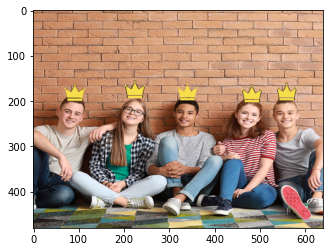

In [325]:
plt.imshow(img_dlib)

---

## 회고 

- 이번 프로젝트를 진행하면서 `WARNING:tensorflow:5 out of the last 5 calls to <function _make_execution_function.<locals>.` 해당 이슈가 발생했습니다.  
어떤 이유로 발생했는지 찾아보니 여러 이유가 있지만, 저의 경우에 의심스러운 원인은 "Driver/library version mismatch" 문제 인것 같습니다.    
이전에 SSD Model을 만들었을때의 tf 버전과 현재의 tf버전이 일치 하지 않았을 가능성이 있는것 같습니다.



- 해커톤을 진행하면서 다른것들을 같이 하니 그만큼 집중도가 떨어지고 잘 안되는것 같습니다.   
아무래도 해커톤에 좀 더 집중하려다 보니 그만큼 노드에 집중도 잘안되고 시간 배분도 잘 안되는게 문제인것 같습니다.
   


- 이번 프로젝트의 경우 아쉬운 요소들도 있고 깔끔하게 진행하지 못한 부분이 아쉽지만 그래도 결과는 나쁘지 않게 나온것 같습니다.